# Visualization

This Jupyter notebook visualizes results for the **pristine BaTiO<sub>3</sub>** system.  
The analysis uses a PyTorch-based Distributed Data Parallel (DDP) implementation trained on NERSC-Perlmutter.


### Training and Evaluation

Training was performed on NERSC using distributed data parallel (DDP) with PyTorch. The model was trained for 90 epochs using alternating VAMP1 and VAMP2 loss functions.

**Hyperparameters:**
- Batch Size: 26
- Learning Rate: 0.0006
- Number of Classes: 3
- Epochs: 90 (30 VAMP2 + 30 VAMP1 + 30 VAMP2)

In [ ]:
import os
import sys

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)
os.chdir(project_root)

print(f"Project root: {project_root}")

In [2]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import yaml
import json

import matplotlib.pyplot as plt
%matplotlib inline

# Project-specific imports (updated paths)
from postprocess.koopman_postprocess import (
    KoopmanAnalysis,
    plot_timescales,
    plot_ck_tests,
    plot_eigenanalysis,
)

# Plotting configuration
plt.rcParams.update({
    'figure.figsize': (8, 5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

### Training Metrics

Plot the training metrics from the 90-epoch training run.

In [ ]:
# Load training metrics from JSON
import json

metrics_path = "<PATH>/training_metrics_.json"
with open(metrics_path, 'r') as f:
    metrics = json.load(f)

epochs = metrics['epochs']
loss_values = metrics['loss_values']
loss_type = metrics['loss_type']
tr_metric1 = metrics['tr_metric1']
tr_metric2 = metrics['tr_metric2']
val_loss = metrics['val_loss']
val_metric1 = metrics['val_metric1']
val_metric2 = metrics['val_metric2']

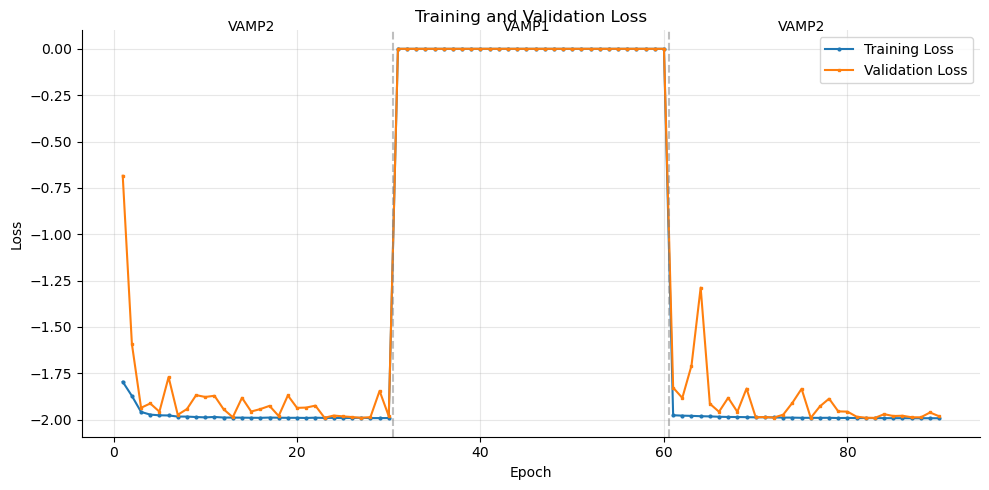

In [4]:
# Plot training and validation loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, loss_values, label='Training Loss', marker='o', markersize=2)
ax.plot(epochs, val_loss, label='Validation Loss', marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

# Add vertical lines to indicate loss type changes
ax.axvline(x=30.5, color='gray', linestyle='--', alpha=0.5, label='Loss type change')
ax.axvline(x=60.5, color='gray', linestyle='--', alpha=0.5)
ax.text(15, ax.get_ylim()[1]*0.95, 'VAMP2', ha='center', fontsize=10)
ax.text(45, ax.get_ylim()[1]*0.95, 'VAMP1', ha='center', fontsize=10)
ax.text(75, ax.get_ylim()[1]*0.95, 'VAMP2', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

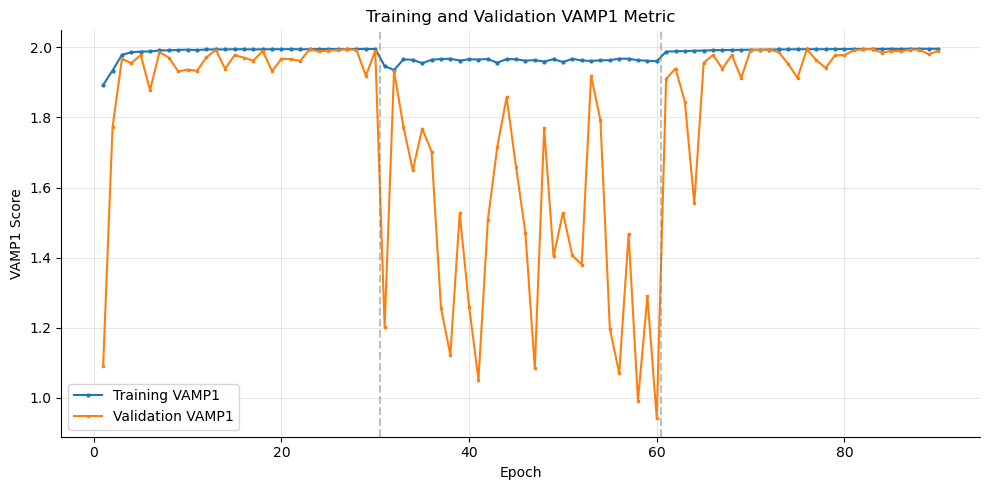

In [5]:
# Plot VAMP1 metrics
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, tr_metric1, label='Training VAMP1', marker='o', markersize=2)
ax.plot(epochs, val_metric1, label='Validation VAMP1', marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('VAMP1 Score')
ax.set_title('Training and Validation VAMP1 Metric')
ax.legend()
ax.axvline(x=30.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=60.5, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

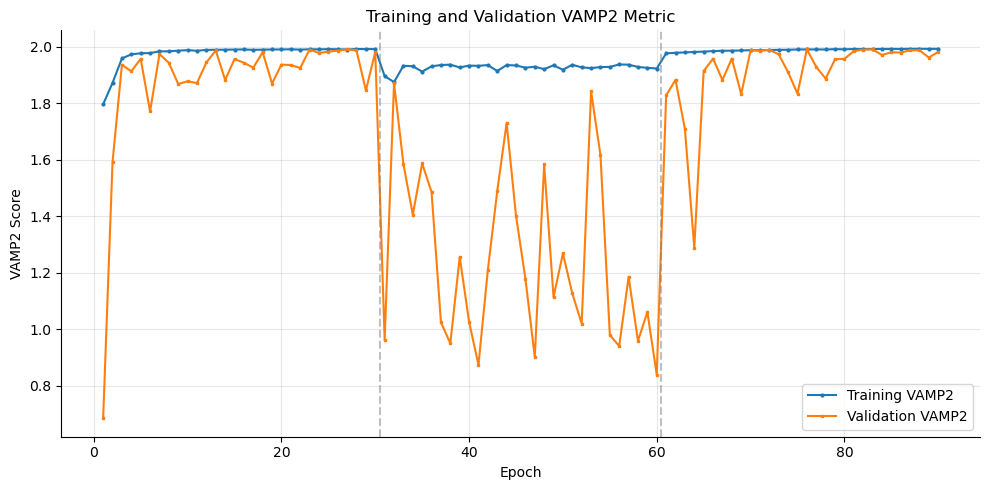

In [6]:
# Plot VAMP2 metrics
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, tr_metric2, label='Training VAMP2', marker='o', markersize=2)
ax.plot(epochs, val_metric2, label='Validation VAMP2', marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('VAMP2 Score')
ax.set_title('Training and Validation VAMP2 Metric')
ax.legend()
ax.axvline(x=30.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=60.5, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Load Predicted State Probabilities

Load the predicted state probabilities of the test dataset.

In [ ]:
preds = np.load("<PATH to preds>/bto_pristine_preds.npy")
# This may not be required if you use analysis_example.ipynb

### State Populations

Generate a pie-chart depicting the populations of individual states.

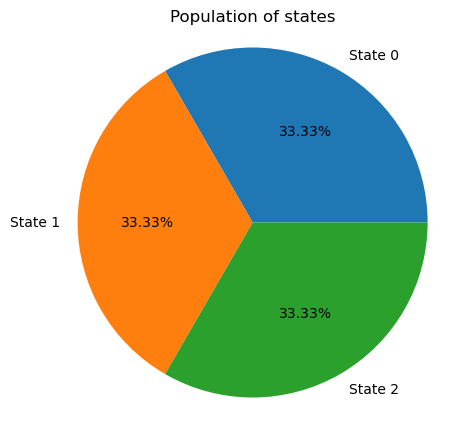

In [8]:
probs = np.sum(preds, axis=(0, 1))
probs = probs / np.sum(probs)
labels = ['State {}'.format(i) for i in range(len(probs))]
plt.figure()
plt.pie(probs, labels=labels, autopct='%1.2f%%')
plt.axis("image")
plt.title('Population of states')
plt.show()

### Relaxation Timescales

Create a plot illustrating the evolution of relaxation timescales as a function of lag time. The relaxation timescales correspond to the characteristic times implied by the transition matrix at a given lag time. The model begins to adhere to the Markovian assumption when the relaxation timescales cease to vary. The lag time array, denoted as `lag`, is used to calculate the relaxation timescales. To estimate uncertainty, the data is divided into `n_splits` segments along the `split_axis` of the `time axis`. The `time_unit_in_ns` variable is used to convert the timesteps into units of nanoseconds.

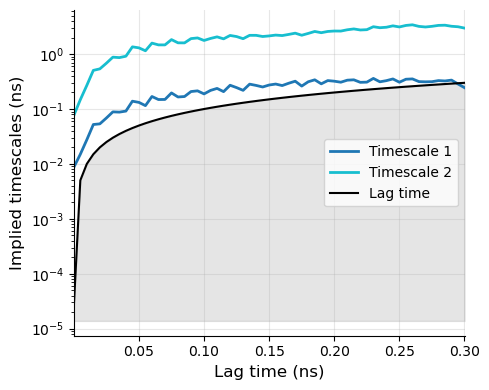

In [ ]:
TIME_UNIT_NS = 25e-6 #Timestep here is 1 fs, so 1e-6 ns 
max_tau = 12090  
lag = np.arange(1, max_tau, 200)
plot_timescales(
    preds, 
    lag, 
    n_splits=1, 
    split_axis=0, 
    time_unit_in_ns=TIME_UNIT_NS);

### Chapman-Kolmogorov Test

Perform CK test. In the above figure, we know that starting at `0.15 ns`, the model starts to follow the Markovian assumption. So the transition matrix with lag time `tau_msm = 6000 (0.15 ns)` should pass the CK test. We perform the CK test with `tau_msm = 6000`. The values predicted by direct multiplication of the transition matrix (blue) and estimated from the trajectory data (red) should match well. Note that we should choose the smallest `tau_msm` because it provides the most detailed dynamical information.

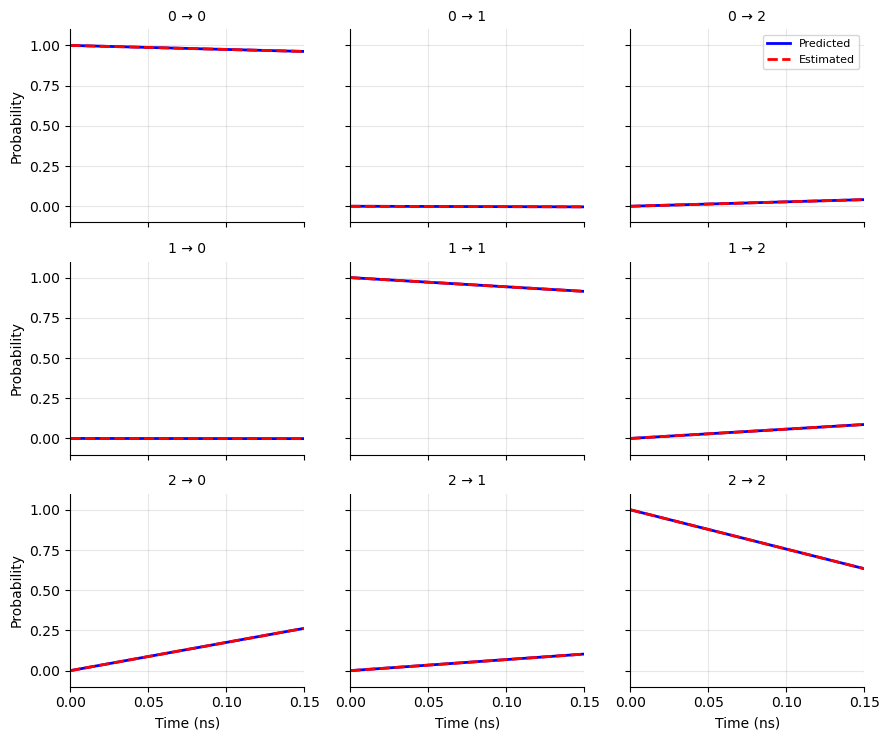

In [10]:
plot_ck_tests(
    preds, 
    tau_msm=6000, 
    steps=2, 
    n_splits=1, 
    split_axis=0, 
    time_unit_in_ns=TIME_UNIT_NS
);

### Eigenvalue Decomposition

Perform eigenvalue decomposition of the Koopman matrix (`koopman_op`). The eigenvectors corresponding to each relaxation mode are plotted. The largest eigenvalue should be 1 with relaxation timescale of infinity. 
- **The second eigenvector shows the transition between `down-domain` and `up-domain`.** 
- **The third eigenvector shows the transition between `domain-wall` and `down-domain`.**

Eig 1
Value: 0.9999999998063055
Timescale: inf (stationary)
Stationary distribution: [0.78648834 0.10096885 0.11254281]
Vector: [0.98201815 0.12607084 0.14052221]

Eig 2
Value: 0.9324200719208533
Timescale: 2.1437193806138364 ns
Vector: [-0.7470669   0.65887235  0.08819454]

Eig 0
Value: 0.5778515546194755
Timescale: 0.2735038899003802 ns
Vector: [ 0.54740696  0.25094804 -0.798355  ]



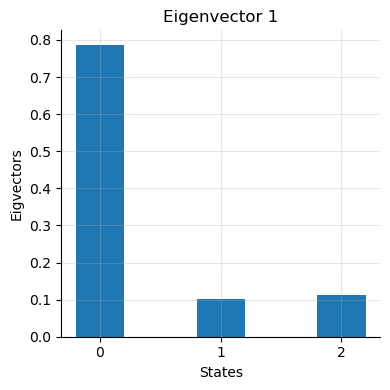

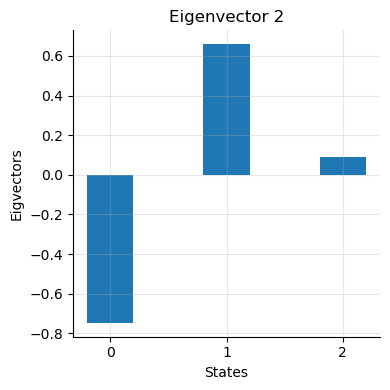

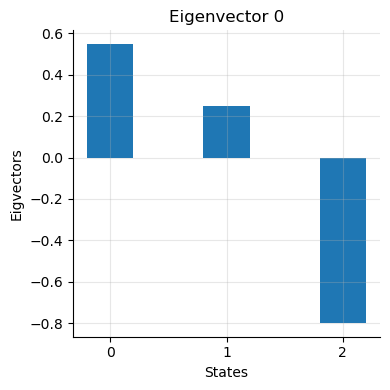

In [11]:
vamp_analyzer = KoopmanAnalysis(epsilon=1e-5)
koopman_op = vamp_analyzer.estimate_koopman_op(preds, 6000)
eigvals, eigvecs = plot_eigenanalysis(
    koopman_op,
    6000,
    time_unit_in_ns=TIME_UNIT_NS
);

### 3D Visualization

Visualize the probability distribution of the states in 3D. Load the trajectory coordinates and map the predicted state probabilities to the target atom indices.

In [ ]:
graph = np.load("<PATH><to_traj_coord.npy> and <target_index.npy/graphs/graphs.npy")

In [15]:

traj_coords = graph['traj_coords']
target_index = graph['target_index'] 

In [19]:
import matplotlib
import matplotlib.cm as get_cmap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def scatter3d(x,y,z, cs, title, colorsMap='jet', angle=30):
    scaler = MinMaxScaler(feature_range=(0,1))
    cs_scaled = scaler.fit_transform(cs.reshape(-1,1)).flatten()

    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs_scaled), vmax=max(cs_scaled))
    scalarMap = get_cmap.ScalarMappable(norm=cNorm, cmap=cm)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
    ax.axis('auto')
    ax.scatter(x, y, z, s=2, c=scalarMap.to_rgba(cs_scaled), marker='.', alpha=0.8)
    scalarMap.set_array(cs_scaled)
    ax.view_init(7, angle)
    
    # create a new Axes instance for the colorbar
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scalarMap, cax=cbar_ax)
    cbar.set_label('Probability')
    
    plt.title(title, ha='center')
    plt.show()

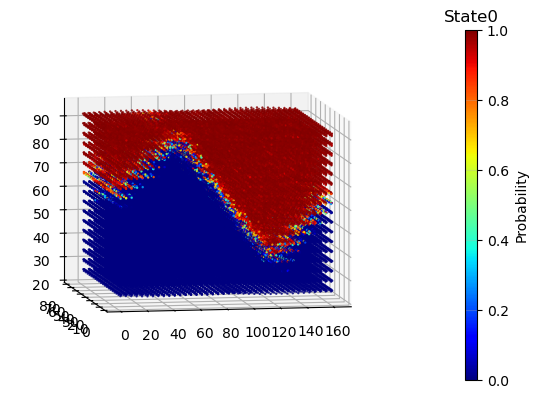

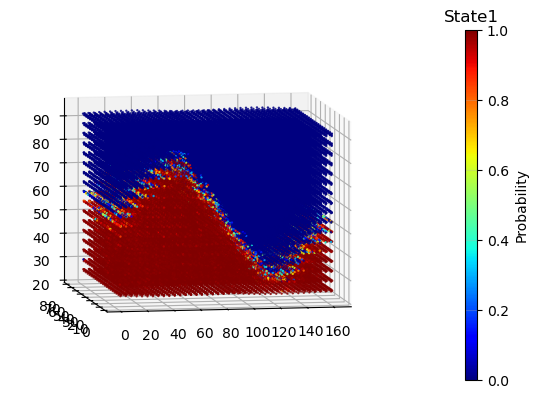

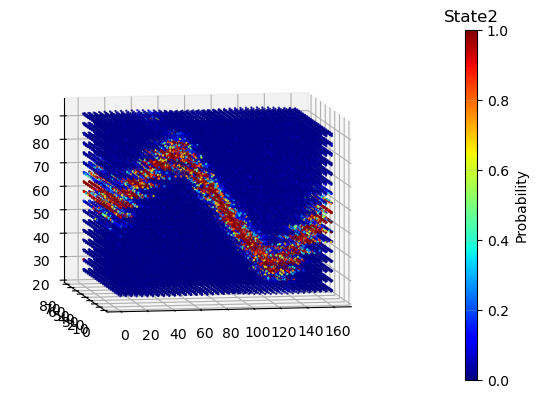

In [20]:
for i in range(3):
    scatter3d(traj_coords[::500, target_index, 0], traj_coords[::500, target_index, 1], traj_coords[::500, target_index, 2],
              cs=(((ppred[::500]).reshape(-1,3))[:,i]), title='State' + str(i),angle=260)
